In [ ]:
import matplotlib as mpl, re, cupy as cp, gc
cmap = mpl.colormaps['tab20']
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 18
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scanpy as sc, numpy as np, os
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib.patches import Patch
from utils import load_model_state, predict
from anndata import AnnData
from scipy.stats import false_discovery_control

In [2]:
root_dir = "combined_analysis/"
cell_types_alias = ["oligo", "astro", "microglia", "L23_IT", "L4_IT", "L5_IT", "L6_IT", "Pvalb", "Sst", "Vip"]
mods = ["rna", "atac"]

In [3]:
def plot_metrics(auroc_df, res_dir):
    aucs = auroc_df['AUROC'].to_list()
    plt.figure(figsize=(8, 6))
    parts = plt.violinplot([aucs], showmeans=True, showmedians=True)
    
    # Customize the violin plot
    for pc in parts['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_alpha(0.7)
    
    # Add scatter plots for individual data points
    x_jitter = np.random.normal(1, 0.04, len(aucs))
    plt.scatter(x_jitter, aucs, alpha=0.7, s=50, color='red', edgecolors='black', linewidth=0.5)
    plt.ylabel('Metric Value')
    plt.title('Distribution of Cross-Validation AUROC')
    plt.grid(True, alpha=0.3)
    plt.xticks([1],["AUROC"])
    plt.tight_layout()
    plt.savefig(f"{res_dir}fold_metrics_plot.png", dpi = 300)
    plt.close()
    print(f"Median AUROC: {np.median(aucs)}, Stdev AUROC: {np.std(aucs)}")

    use_metric = 'AUROC'
    auroc_df['ids'] = auroc_df['test_pair'].str.strip('[]').str.split(', ')
    df_exploded = auroc_df.explode('ids')
    
    # mean, SD, n per id
    stats = (df_exploded.groupby('ids')[use_metric]
             .agg(mean='mean', sd='std', n='count')
             .reset_index())
    
    # standard error; fill NaN (n=1) with 0 so bars plot cleanly
    stats['sem'] = (stats['sd'] / np.sqrt(stats['n'])).fillna(0)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(stats['ids'], stats['mean'],
           yerr=stats['sem'], capsize=4,
           error_kw={'elinewidth':1, 'alpha':0.8})
    
    ax.set_xlabel('ID', fontsize = 16)
    ax.set_ylabel('Average AUROC', fontsize = 16)
    ax.set_title('Average AUROC by donor', fontsize = 25)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelrotation=45)  # or 30/60/90
    
    # red dashed reference line (your code used 0.8)
    ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1)
    
    plt.tight_layout()
    plt.savefig(f"{res_dir}donor_avg_metrics_plot.png", dpi = 300)
    plt.close()

In [4]:
def group_imp_score(result_dir, features_dir, param_df, feature_name, col_name):
    selections = (param_df["AUROC"] > 0.7).to_list()
    all_dfs = []
    for i, keep in enumerate(selections):
        if keep:
            path = os.path.join(features_dir, f"{feature_name}_shap_importance_fold{i}.csv")
            df = pd.read_csv(path)
            df["frac_imp"] = df["Importance"] / df["Importance"].sum() * 1000
            all_dfs.append(df)
    
    # combine them end-to-end
    df_all = pd.concat(all_dfs, ignore_index=True)
    ranked = (
        df_all
        .groupby(col_name)["frac_imp"]
        .mean()
        .sort_values(ascending=False)
    )

    save_name = os.path.join(result_dir, f"common_{feature_name}_importance.csv")
    ranked.to_csv(save_name, index = True)
    imp_df = pd.read_csv(save_name)
    return imp_df

**Plot out common set of genes with their logCPM** <br>
Get the intersection of top 100 genes with highest avg contribution to importance in all fold, perform GO, and plot out logCPM <br>
Folds with AUROC below 0.7 are not used

In [5]:
def plot_imp(imp, result_dir):
    last = imp.shape[0] - 1
    plt.figure(figsize = (15,5))
    xvals = np.arange(imp.shape[0])
    plt.title(f"{col_name} importance score curve (sorted from high to low)")
    plt.xlabel(f"number of {feature_name}")
    plt.ylabel("fractional importance (out of 1000)")
    plt.scatter(xvals, imp)
    plt.plot([0,last], [imp[0], imp[last]], label = "Linear decrease", color = "red")
    plt.legend()
    plt.savefig(f"{result_dir}importance_score_plot.png", dpi = 300)
    plt.close()

In [6]:
def elbow_cutoff_distance(imp, result_dir):
    y = np.asarray(imp, float)
    y = np.sort(y)[::-1]              # rank high -> low
    n  = y.size
    x  = np.arange(n, dtype=float)

    # chord first->last
    x1, y1 = 0.0,   y[0]
    x2, y2 = n-1.0, y[-1]
    dx, dy = (x2 - x1), (y2 - y1)
    denom  = np.hypot(dx, dy)

    # perpendicular distance of each (x,y) to the chord (no np.cross)
    dist = np.abs(dy*(x - x1) - dx*(y - y1)) / denom

    idx   = int(np.argmax(dist))   # 0-based elbow index
    plot_imp(imp, result_dir)
    return idx

In [7]:
def block_enrich_gpu_strat_private(
    imp_df: pd.DataFrame,
    adata: AnnData, result_dir, col_name,
    B=20000, batch=2000, n_bins=10, block=50, kmax=2000, seed=0
):
    # 2. pull out only those genes (this makes a dense DataFrame)
    df = adata.to_df()
    
    # 3. add your grouping column
    df['group'] = adata.obs['orig.ident']
    
    # 4. aggregate counts per group (sum for total counts, mean for avg expression…)
    grouped_mean   = df.groupby('group').mean().T  # average expression per group, genes as rows

    expr_raw = grouped_mean.mean(axis = 1)

    imp_raw = imp_df.set_index(col_name)["frac_imp"].astype(float)
    common = expr_raw.index.intersection(imp_raw.index)
    
    # aligned, with imp's ranking preserved
    imp  = imp_raw.loc[common]
    expr = expr_raw.loc[common]
    
    # ---- prep: rank by importance & make expression bins (label-agnostic) ----
    imp = imp_df.set_index(col_name)["frac_imp"].astype(float)
    expr = expr.reindex(imp.index).astype(float)
    order = np.argsort(-imp.values)                                  # high -> low
    v = cp.asarray(imp.values[order], dtype=cp.float32)              # sorted importances
    bins_pd = pd.qcut(expr.values[order], q=n_bins, labels=False, duplicates="drop")
    bins = cp.asarray(bins_pd, dtype=cp.int32)
    n_bins_eff = int(bins_pd.max()) + 1
    n = int(v.size)
    tot = float(v.sum().get())

    # keep only full 50-gene blocks up to kmax
    n_keep   = min(kmax, (n // block) * block)
    n_blocks = n_keep // block
    cp.random.seed(seed)

    # pools per expression bin
    idx_by_bin = [cp.where(bins == b)[0] for b in range(n_bins_eff)]

    # ---- per-block Monte-Carlo: expression-matched sampling ----
    P  = np.empty(n_blocks)
    NES = np.empty(n_blocks)
    mass = np.empty(n_blocks)
    for bi in range(n_blocks):
        s, e = bi * block, (bi + 1) * block
        obs_sum = float(v[s:e].sum().get())
        mass[bi] = obs_sum / tot
        cnt = cp.bincount(bins[s:e], minlength=n_bins_eff).get()     # how many from each bin in this block

        ge = 0; s1 = 0.0; s2 = 0.0; done = 0
        while done < B:
            cur = min(batch, B - done)
            total = cp.zeros(cur, dtype=cp.float32)
            for b in range(n_bins_eff):
                c = int(cnt[b])
                if c == 0: continue
                pool = idx_by_bin[b]
                # sample c without replacement per row via argpartition trick
                r = cp.random.random((cur, pool.size), dtype=cp.float32)
                sel = cp.argpartition(r, c-1, axis=1)[:, :c]
                total += v[pool][sel].sum(axis=1)
            ge += int((total >= obs_sum).sum().get())
            t = total.astype(cp.float64)
            s1 += float(t.sum().get()); s2 += float((t*t).sum().get())
            done += cur

        mu = s1 / B
        sd = max(0.0, s2 / B - mu * mu) ** 0.5
        NES[bi] = (obs_sum - mu) / (sd if sd > 0 else 1.0)
        P[bi]   = (ge + 1) / (B + 1)

    # ---- BH-FDR across blocks ----

    df = pd.DataFrame({
        "block": np.arange(n_blocks),
        "k_cut": np.arange(n_blocks) * block,
        "block_mass": mass, "NES": NES, "p": P
    })

    df["FDR"] = false_discovery_control(df["p"])
    df.to_csv(f"{result_dir}imp_score_enrichment_df.csv", index = False)

    # cutoff = end of last significant block (q < 0.05); 0 if none
    sig = np.where(df["FDR"].values < 0.05)[0]
    k_cut = int(df["k_cut"].iloc[sig.max()]) if sig.size else 0
    # m = df["FDR"] < 0.05
    # k_cut = int(df.loc[m, "k_cut"].iloc[0]) if m.any() else 0

    plt.scatter(df["k_cut"], df['FDR'])
    plt.title("FDR vs. num. features selected")
    plt.xlabel(f"num. {col_name}")
    plt.ylabel("FDR")
    plt.savefig(f"{result_dir}pval_enrich_imp_score_plot.png", dpi = 300)
    plt.close()
    return k_cut

In [8]:
def hard_labels_and_median_proba(adata, auroc_df, models, obsm_key="X_pca", donor_col="orig.ident"):
    X = adata.obsm[obsm_key]
    donors = adata.obs[donor_col].to_numpy()

    # parse per-fold pairs and thresholds
    pairs = (
        auroc_df["test_pair"]
        .astype(str)
        .str.extract(r"\[\s*(-?\d+)\s*,\s*(-?\d+)\s*\]")
        .astype(int)
        .to_numpy()  # (n_folds, 2)
    )
    folds = auroc_df["Fold"].to_numpy(int)
    thr_map = dict(zip(folds, auroc_df["threshold"].astype(float)))

    # donor -> folds containing that donor
    d2f = defaultdict(list)
    for f, (a, b) in zip(folds, pairs):
        d2f[a].append(f); d2f[b].append(f)

    y_out    = np.zeros(X.shape[0], dtype=np.uint8)       # final hard labels
    pmed_out = np.full(X.shape[0], np.nan, dtype=float)   # median probs

    for d in pd.unique(donors):
        idx = np.flatnonzero(donors == d)
        fs  = d2f.get(d, [])
        if not fs or idx.size == 0:
            continue

        # probs from each relevant model for this donor's cells
        P = np.column_stack([predict(models[f], X[idx]).squeeze() for f in fs])  # (cells_donor, n_models)
        p_med = np.median(P, axis=1)
        pmed_out[idx] = p_med

        # per-model hard calls using each model's own threshold
        B = np.column_stack([(P[:, j] >= thr_map[fs[j]]).astype(np.uint8) for j in range(len(fs))])
        y_out[idx] = (B.mean(axis=1) >= 0.5).astype(np.uint8)  # majority vote

    return y_out, pmed_out  # (N,), (N,)

In [9]:
def predict_plot_proba(model_dir, adata, auroc_df, save_dir):
    model_paths = os.listdir(model_dir)
    def fold_num(name: str) -> int:
        return int(re.search(r"fold(\d+)_", name).group(1))
    
    mp_sorted = sorted(model_paths, key=fold_num)
    models = [load_model_state(model_dir + mp, input_dim = adata.obsm["X_pca"].shape[1]) for mp in mp_sorted]
    _, avg_proba = hard_labels_and_median_proba(adata, auroc_df, models, "X_pca", "orig.ident")
    print(f"Check avg_proba: {avg_proba}")

    pd.DataFrame({"barcodes":adata.obs_names, "avg_proba":avg_proba}).to_csv(f"{save_dir}cell_proba.csv", index = False)

    status = (pd.DataFrame({"donor": np.asarray(adata.obs["orig.ident"]),
                        "diag":  adata.obs["AD"].astype(str)})
          .drop_duplicates("donor"))
    is_ad = status.set_index("donor")["diag"].str.contains("AD", case=False, regex=True).to_dict()
    
    df = pd.DataFrame({"donor": adata.obs["orig.ident"], "p": avg_proba})
    donors = sorted(df['donor'].unique())
    per_plot = 20
    for i in range(0, len(donors), per_plot):
        dn = donors[i:i+per_plot]
        groups = [df.loc[df.donor == d, "p"].values for d in dn]
        colors = ["tab:red" if is_ad.get(d, False) else "tab:blue" for d in dn]
    
        fig, ax = plt.subplots(figsize=(max(12, 1.2*len(dn)), 6))
        parts = ax.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)
        for b, c in zip(parts["bodies"], colors):
            b.set_facecolor(c); b.set_edgecolor("black"); b.set_alpha(0.85)
    
        ax.set_xticks(np.arange(1, len(dn)+1)); ax.set_xticklabels([str(d) for d in dn], rotation=90)
        ax.set_ylabel("AD probability", ); ax.set_xlabel("Donor (orig.ident)")
        ax.set_title(f"Per-donor AD probability (donors {i+1}-{i+len(dn)} of {len(donors)})")
        ax.axhline(0.5, ls="--", lw=1)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"donor_proba_{i+1}-{i+len(dn)}_of_{len(donors)}.png"))
        plt.close()

In [10]:
elbow_cut_gene, pval_cut_gene, elbow_cut_peak, pval_cut_peak = list(), list(), list(), list()
gene_num, peak_num = list(), list()
for ct in cell_types_alias:
    for mod in mods:
        print(f"Processing: {ct}, {mod}")
        if mod == "rna":
            feature_name, col_name = "gene", "Gene"
        elif mod == "atac":
            feature_name, col_name = "peak", "Peak"
        else:
            raise ValueError("Modality name invalid, choose rna or atac")
        
        result_dir = f"{root_dir}result/{ct}/{mod}/"
        adata = sc.read_h5ad(f"{root_dir}adata_objects/{ct}_mgh_{mod}_v3_precomp.h5ad")
        features_dir = os.path.join(result_dir, f"{feature_name}_importance/")
        model_dir = os.path.join(result_dir,"models/")

        # Group and save importance scores
        param_df = pd.read_csv(os.path.join(result_dir,"fold_metrics.csv"))
        plot_metrics(param_df, result_dir)
        print("Plotted metrics")
        predict_plot_proba(model_dir, adata, param_df, result_dir)
        print("Saved single cell probabilities")
        imp_df = group_imp_score(result_dir, features_dir, param_df, feature_name, col_name)
        print("Grouped importance scores")

        if mod == "rna":
            gene_num.append(imp_df.shape[0])
            elbow_cut_gene.append(elbow_cutoff_distance(imp_df["frac_imp"], result_dir))
            pval_cut_gene.append(block_enrich_gpu_strat_private(imp_df, adata, result_dir, col_name, B=20000, 
                                                                batch=2000, n_bins=10, seed=42))
        if mod == "atac":
            peak_num.append(imp_df.shape[0])
            elbow_cut_peak.append(elbow_cutoff_distance(imp_df["frac_imp"], result_dir))
            pval_cut_peak.append(block_enrich_gpu_strat_private(imp_df, adata, result_dir, col_name, B=20000, 
                                                                batch=2000, n_bins=10, kmax = 20000, seed=42))
        print(f"Processed: {ct}, {mod}")
        print("\n")

Processing: oligo, rna
Median AUROC: 0.9475242165302455, Stdev AUROC: 0.23308692278252768
Plotted metrics
Check avg_proba: [1.35161390e-05 4.72208165e-04 3.46834719e-01 ... 2.27529765e-03
 2.46506584e-08 4.29305828e-06]
Saved single cell probabilities
Grouped importance scores
Processed: oligo, rna


Processing: oligo, atac
Median AUROC: 0.9383368093816034, Stdev AUROC: 0.1415686543262491
Plotted metrics
Check avg_proba: [2.51555903e-04 3.80791142e-04 2.89447665e-01 ... 6.89011067e-02
 1.91784580e-04 1.20161720e-01]
Saved single cell probabilities
Grouped importance scores
Processed: oligo, atac


Processing: astro, rna
Median AUROC: 0.9550110492277157, Stdev AUROC: 0.1786795362132342
Plotted metrics
Check avg_proba: [3.07545695e-03 1.77728862e-06 4.77264971e-02 ... 3.47679998e-05
 9.01629448e-07 1.56248420e-01]
Saved single cell probabilities
Grouped importance scores
Processed: astro, rna


Processing: astro, atac
Median AUROC: 0.912244233198998, Stdev AUROC: 0.16438277200917173
Plot

In [11]:
cut_df = pd.DataFrame({"cell_type":cell_types_alias, "elbow_cut_gene":elbow_cut_gene, "pval_based_cut_gene": pval_cut_gene, "total_gene": gene_num,
                      "elbow_cut_peak":elbow_cut_peak, "pval_based_cut_peak": pval_cut_peak, "total_peak": peak_num})

In [12]:
cut_df.to_csv(f"{root_dir}cell_types_feature_cutoffs.csv", index = False)
cut_df.head()

,cell_type,elbow_cut_gene,pval_based_cut_gene,total_gene,elbow_cut_peak,pval_based_cut_peak,total_peak
0,oligo,1360,400,12347,1869,2050,72317
1,astro,1374,750,14287,8877,5350,146066
2,microglia,1134,1100,12809,6667,19050,85132
3,L23_IT,1356,800,17393,13545,19850,212761
4,L4_IT,979,800,17325,14190,19950,195216


### Visualization

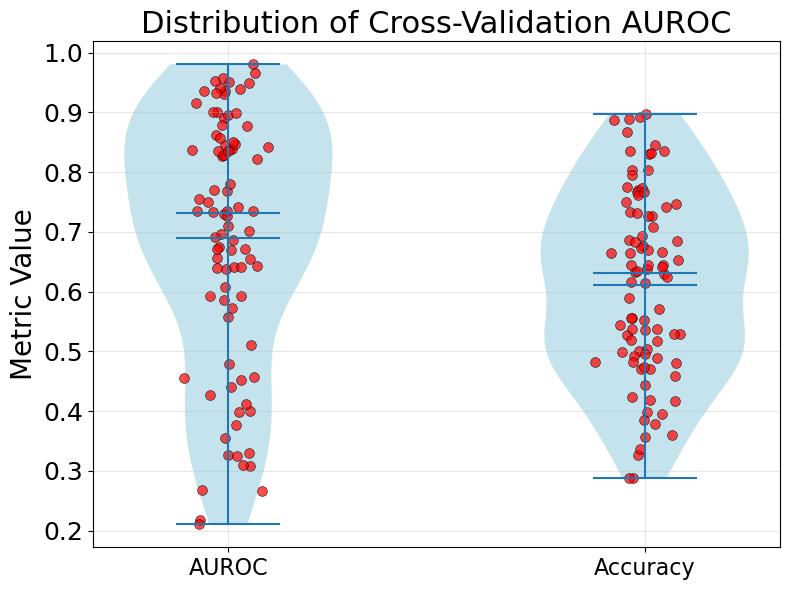

Median AUROC: 0.7318771038578205, Stdev AUROC: 0.20893779480736197
Median Accuracy: 0.6307467464013954, Stdev Accuracy: 0.15541899505865114


In [7]:
auroc_df = pd.read_csv(os.path.join(result_dir, "fold_metrics.csv"))
aucs = auroc_df['AUROC'].to_list()
accs = auroc_df['Accuracy'].to_list()
# Create violin plot
plt.figure(figsize=(8, 6))
parts = plt.violinplot([aucs, accs], showmeans=True, showmedians=True)

# Customize the violin plot
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)

# Add scatter plots for individual data points
x_jitter = np.random.normal(1, 0.04, len(aucs))
x2 = np.random.normal(2, 0.04, len(accs))
plt.scatter(x_jitter, aucs, alpha=0.7, s=50, color='red', edgecolors='black', linewidth=0.5)
plt.scatter(x2, accs, alpha=0.7, s=50, color='red', edgecolors='black', linewidth=0.5)
plt.ylabel('Metric Value')
plt.title('Distribution of Cross-Validation AUROC')
plt.grid(True, alpha=0.3)
plt.xticks([1,2],["AUROC", "Accuracy"])
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print(f"Median AUROC: {np.median(aucs)}, Stdev AUROC: {np.std(aucs)}")
print(f"Median Accuracy: {np.median(accs)}, Stdev Accuracy: {np.std(accs)}")

**Donor correlation with metrics**

In [8]:
df = pd.read_csv(os.path.join(result_dir,"fold_metrics.csv"))

In [9]:
use_metric = 'AUROC'

In [10]:
df['ids'] = df['test_pair'].str.strip('[]').str.split(', ')
df_exploded = df.explode('ids')

# mean, SD, n per id
stats = (df_exploded.groupby('ids')[use_metric]
         .agg(mean='mean', sd='std', n='count')
         .reset_index())

# standard error; fill NaN (n=1) with 0 so bars plot cleanly
stats['sem'] = (stats['sd'] / np.sqrt(stats['n'])).fillna(0)

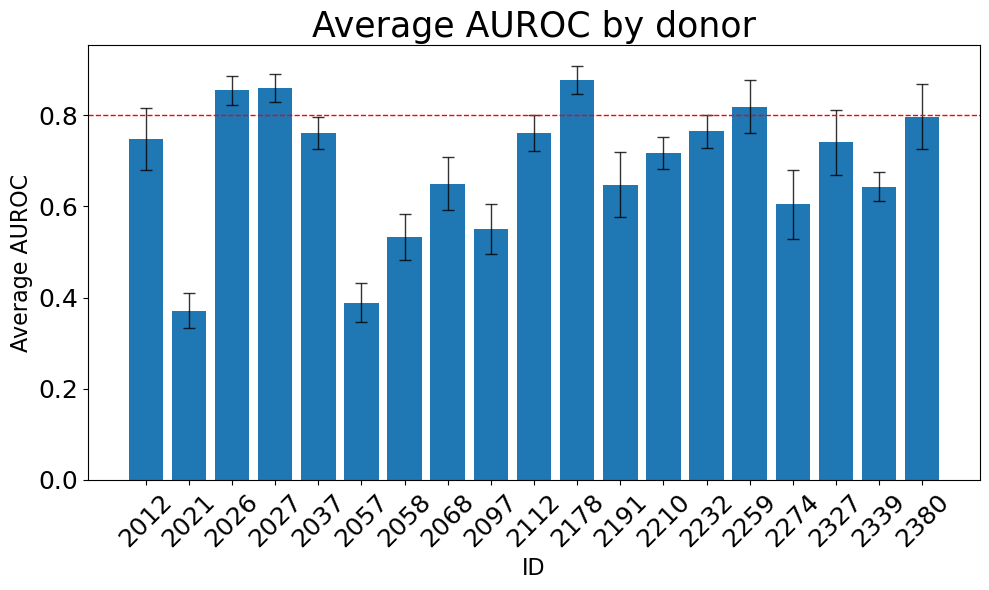

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(stats['ids'], stats['mean'],
       yerr=stats['sem'], capsize=4,
       error_kw={'elinewidth':1, 'alpha':0.8})

ax.set_xlabel('ID', fontsize = 16)
ax.set_ylabel('Average AUROC', fontsize = 16)
ax.set_title('Average AUROC by donor', fontsize = 25)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelrotation=45)  # or 30/60/90

# red dashed reference line (your code used 0.8)
ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

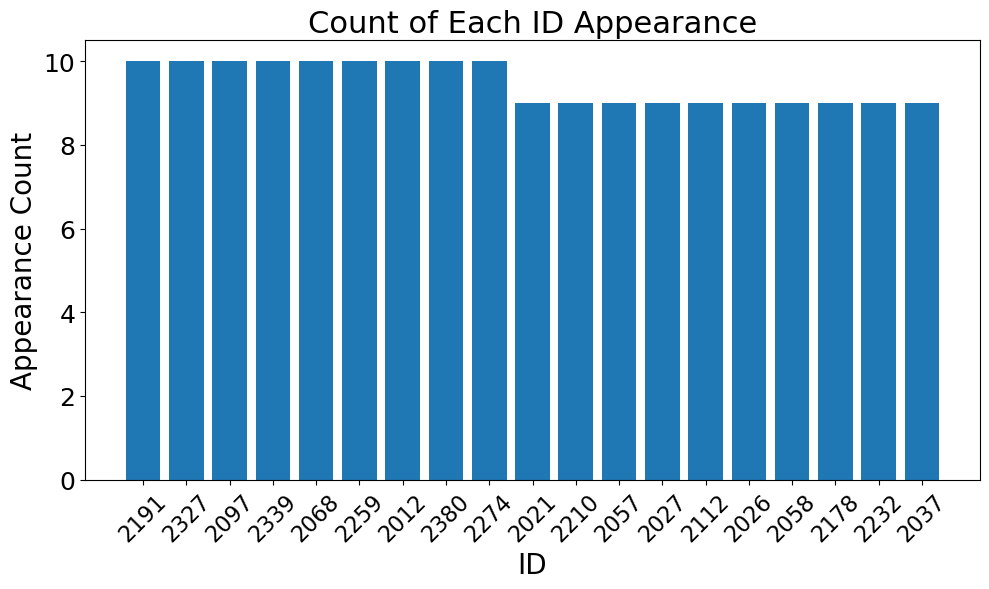

In [12]:
counts = df_exploded['ids'].value_counts().reset_index()
counts.columns = ['ID', 'Count']

# Plot as a barplot
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(counts['ID'], counts['Count'])
ax.set_xlabel('ID')
ax.set_ylabel('Appearance Count')
ax.set_title('Count of Each ID Appearance')
ax.tick_params(axis='x', labelrotation=45)  # or 30/60/90
plt.tight_layout()
plt.show()

**Predict donor-level labels**

In [13]:
adata

AnnData object with n_obs × n_vars = 5415 × 118907
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet.filter', 'Jorstard.pred', 'harmony_clusters', 'seurat_clusters', 'remove_or_not', 'unintegrated_clusters', 'AD', 'Subclass', 'Subclass_fct', 'class', 'brain.region', 'barcode', 'nCount_ATAC', 'nFeature_ATAC', 'n_counts', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [14]:
auroc_df = pd.read_csv(os.path.join(result_dir,"fold_metrics.csv"))

In [15]:
auroc_df.head()

,Fold,test_pair,AUROC,Accuracy,threshold
0,0,"[2210, 2191]",0.656170,0.628877,0.399478
1,1,"[2021, 2191]",0.325808,0.499157,0.569827
2,2,"[2112, 2097]",0.592246,0.470000,0.461551
3,3,"[2027, 2327]",0.935756,0.733333,0.536210
4,4,"[2057, 2012]",0.451992,0.397959,0.507925


In [16]:
model_paths = os.listdir(model_dir)
def fold_num(name: str) -> int:
    return int(re.search(r"fold(\d+)_", name).group(1))

mp_sorted = sorted(model_paths, key=fold_num)

In [17]:
# PyTorch model loading
models = [load_model_state(model_dir + mp, input_dim = adata.obsm["X_pca"].shape[1]) for mp in mp_sorted]

In [18]:
len(models)

90

**PyTorch donor label prediction**

In [19]:
def hard_labels_and_median_proba(adata, auroc_df, models, obsm_key="X_pca", donor_col="orig.ident"):
    X = adata.obsm[obsm_key]
    donors = adata.obs[donor_col].to_numpy()

    # parse per-fold pairs and thresholds
    pairs = (
        auroc_df["test_pair"]
        .astype(str)
        .str.extract(r"\[\s*(-?\d+)\s*,\s*(-?\d+)\s*\]")
        .astype(int)
        .to_numpy()  # (n_folds, 2)
    )
    folds = auroc_df["Fold"].to_numpy(int)
    thr_map = dict(zip(folds, auroc_df["threshold"].astype(float)))

    # donor -> folds containing that donor
    d2f = defaultdict(list)
    for f, (a, b) in zip(folds, pairs):
        d2f[a].append(f); d2f[b].append(f)

    y_out    = np.zeros(X.shape[0], dtype=np.uint8)       # final hard labels
    pmed_out = np.full(X.shape[0], np.nan, dtype=float)   # median probs

    for d in pd.unique(donors):
        idx = np.flatnonzero(donors == d)
        fs  = d2f.get(d, [])
        if not fs or idx.size == 0:
            continue

        # probs from each relevant model for this donor's cells
        P = np.column_stack([predict(models[f], X[idx]).squeeze() for f in fs])  # (cells_donor, n_models)
        p_med = np.median(P, axis=1)
        pmed_out[idx] = p_med

        # per-model hard calls using each model's own threshold
        B = np.column_stack([(P[:, j] >= thr_map[fs[j]]).astype(np.uint8) for j in range(len(fs))])
        y_out[idx] = (B.mean(axis=1) >= 0.5).astype(np.uint8)  # majority vote

    return y_out, pmed_out  # (N,), (N,)

In [20]:
cell_labels, avg_proba = hard_labels_and_median_proba(adata, auroc_df, models, "X_pca", "orig.ident")

In [21]:
cell_labels

array([0, 0, 1, ..., 0, 0, 1], shape=(5415,), dtype=uint8)

In [22]:
avg_proba

array([0.29627454, 0.31748611, 0.82474518, ..., 0.14603215, 0.33692828,
       0.76352406], shape=(5415,))

In [23]:
# Median cell proba to predict donor label prediction
donor_pred = (
    pd.DataFrame({"orig.ident": adata.obs["orig.ident"].values, "p": avg_proba})
    .groupby("orig.ident")["p"].median()
    .gt(0.5).astype(int)
)

# donor-level ground truth (0=Control, 1=AD)
label_map = {"Control": 0, "AD": 1}
donor_true = (
    adata.obs.groupby("orig.ident")["AD"].first().map(label_map).astype(int)
)

# accuracy
acc = (donor_true.to_numpy() == donor_pred.to_numpy()).mean()
print(acc)

0.631578947368421


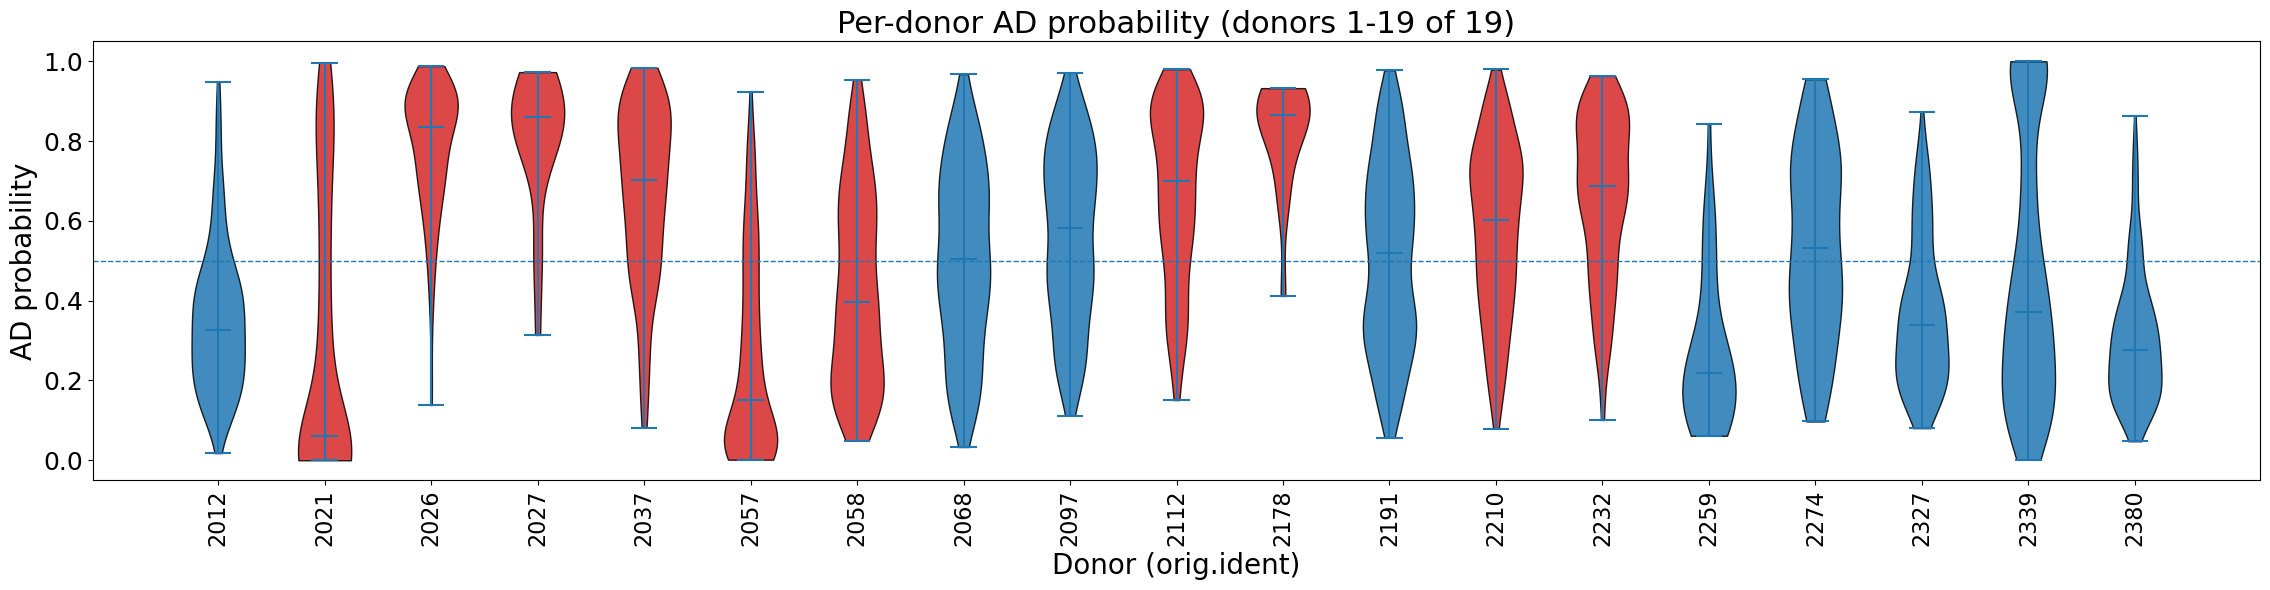

In [24]:
status = (pd.DataFrame({"donor": np.asarray(adata.obs["orig.ident"]),
                        "diag":  adata.obs["AD"].astype(str)})
          .drop_duplicates("donor"))
is_ad = status.set_index("donor")["diag"].str.contains("AD", case=False, regex=True).to_dict()

df = pd.DataFrame({"donor": adata.obs["orig.ident"], "p": avg_proba})
donors = sorted(df['donor'].unique())
per_plot = 20
for i in range(0, len(donors), per_plot):
    dn = donors[i:i+per_plot]
    groups = [df.loc[df.donor == d, "p"].values for d in dn]
    colors = ["tab:red" if is_ad.get(d, False) else "tab:blue" for d in dn]

    fig, ax = plt.subplots(figsize=(max(12, 1.2*len(dn)), 6))
    parts = ax.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)
    for b, c in zip(parts["bodies"], colors):
        b.set_facecolor(c); b.set_edgecolor("black"); b.set_alpha(0.85)

    ax.set_xticks(np.arange(1, len(dn)+1)); ax.set_xticklabels([str(d) for d in dn], rotation=90)
    ax.set_ylabel("AD probability", ); ax.set_xlabel("Donor (orig.ident)")
    ax.set_title(f"Per-donor AD probability (donors {i+1}-{i+len(dn)} of {len(donors)})")
    ax.axhline(0.5, ls="--", lw=1)
    plt.tight_layout()
    os.makedirs(os.path.join(result_dir, "donor_proba_plot"), exist_ok = True)
    plt.savefig(os.path.join(result_dir, f"donor_proba_plot/donor_proba_{i+1}-{i+len(dn)}_of_{len(donors)}.png"))
    plt.show()

## Determine the cutoff percentage of genes

**Importance score based cutoff**

In [70]:
imp_df = pd.read_csv(os.path.join(result_dir, "common_genes_importance.csv"))

In [71]:
imp_df.head()

,Peak,frac_imp
0,chr1-16913821-16914320,0.087010
1,chr10-132537302-132537801,0.076784
2,chr4-37686273-37686772,0.066093
3,chr11-44565157-44565656,0.061188
4,chr9-93095805-93096304,0.059871


In [72]:
imp_df.shape

(143709, 2)

In [73]:
imp = imp_df['frac_imp']
last = imp.shape[0] - 1

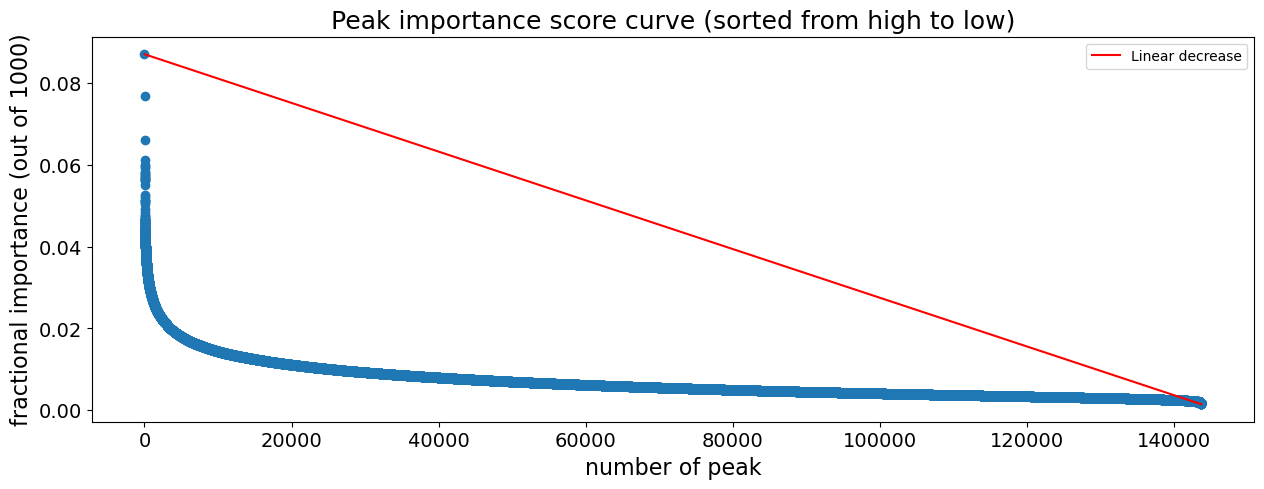

In [75]:
plt.figure(figsize = (15,5))
xvals = np.arange(imp.shape[0])
plt.title(f"{col_name} importance score curve (sorted from high to low)")
plt.xlabel(f"number of {feature_name}")
plt.ylabel("fractional importance (out of 1000)")
plt.scatter(xvals, imp)
plt.plot([0,last], [imp[0], imp[last]], label = "Linear decrease", color = "red")
plt.legend()

In [76]:
def elbow_cutoff_distance(imp):
    y = np.asarray(imp, float)
    y = np.sort(y)[::-1]              # rank high -> low
    n  = y.size
    x  = np.arange(n, dtype=float)

    # chord first->last
    x1, y1 = 0.0,   y[0]
    x2, y2 = n-1.0, y[-1]
    dx, dy = (x2 - x1), (y2 - y1)
    denom  = np.hypot(dx, dy)

    # perpendicular distance of each (x,y) to the chord (no np.cross)
    dist = np.abs(dy*(x - x1) - dx*(y - y1)) / denom

    idx   = int(np.argmax(dist))   # 0-based elbow index
    k_cut = idx + 1                # keep top k_cut genes
    return k_cut, idx

In [77]:
k_cut, _ = elbow_cutoff_distance(imp_df["frac_imp"])
top_genes = imp_df.sort_values("frac_imp", ascending=False).head(k_cut)
k_cut

8670

**Competitive null**

In [9]:
# 2. pull out only those genes (this makes a dense DataFrame)
df = adata.to_df()

# 3. add your grouping column
df['group'] = adata.obs['orig.ident']

# 4. aggregate counts per group (sum for total counts, mean for avg expression…)
grouped_mean   = df.groupby('group').mean().T  # average expression per group, genes as rows

In [10]:
expr_raw = grouped_mean.mean(axis = 1)

In [16]:
imp_raw = imp_df.set_index("Gene")["frac_imp"].astype(float)
common = expr_raw.index.intersection(imp_raw.index)

# aligned, with imp's ranking preserved
imp  = imp_raw.loc[common]
expr = expr_raw.loc[common]

In [24]:
def block_enrich_gpu_strat_private(
    imp_df: pd.DataFrame,      # columns: ["Gene","frac_imp"], private importances (sum ~ 1000), high->low
    expr: pd.Series,           # donor-averaged expression (index=Gene), from the same private dataset
    B=20000, batch=2000, n_bins=10, block=50, kmax=5000, seed=0
):
    # ---- prep: rank by importance & make expression bins (label-agnostic) ----
    imp = imp_df.set_index("Gene")["frac_imp"].astype(float)
    expr = expr.reindex(imp.index).astype(float)
    order = np.argsort(-imp.values)                                  # high -> low
    v = cp.asarray(imp.values[order], dtype=cp.float32)              # sorted importances
    bins_pd = pd.qcut(expr.values[order], q=n_bins, labels=False, duplicates="drop")
    bins = cp.asarray(bins_pd, dtype=cp.int32)
    n_bins_eff = int(bins_pd.max()) + 1
    n = int(v.size)
    tot = float(v.sum().get())

    # keep only full 50-gene blocks up to kmax
    n_keep   = min(kmax, (n // block) * block)
    n_blocks = n_keep // block
    cp.random.seed(seed)

    # pools per expression bin
    idx_by_bin = [cp.where(bins == b)[0] for b in range(n_bins_eff)]

    # ---- per-block Monte-Carlo: expression-matched sampling ----
    P  = np.empty(n_blocks)
    NES = np.empty(n_blocks)
    mass = np.empty(n_blocks)
    for bi in range(n_blocks):
        s, e = bi * block, (bi + 1) * block
        obs_sum = float(v[s:e].sum().get())
        mass[bi] = obs_sum / tot
        cnt = cp.bincount(bins[s:e], minlength=n_bins_eff).get()     # how many from each bin in this block

        ge = 0; s1 = 0.0; s2 = 0.0; done = 0
        while done < B:
            cur = min(batch, B - done)
            total = cp.zeros(cur, dtype=cp.float32)
            for b in range(n_bins_eff):
                c = int(cnt[b])
                if c == 0: continue
                pool = idx_by_bin[b]
                # sample c without replacement per row via argpartition trick
                r = cp.random.random((cur, pool.size), dtype=cp.float32)
                sel = cp.argpartition(r, c-1, axis=1)[:, :c]
                total += v[pool][sel].sum(axis=1)
            ge += int((total >= obs_sum).sum().get())
            t = total.astype(cp.float64)
            s1 += float(t.sum().get()); s2 += float((t*t).sum().get())
            done += cur

        mu = s1 / B
        sd = max(0.0, s2 / B - mu * mu) ** 0.5
        NES[bi] = (obs_sum - mu) / (sd if sd > 0 else 1.0)
        P[bi]   = (ge + 1) / (B + 1)

    # ---- BH-FDR across blocks ----
    order_p = np.argsort(P); q = np.empty_like(P); m = len(P); run = 1.0
    for rank, j in enumerate(order_p, 1):
        run = min(run, P[j] * m / rank); q[j] = run

    df = pd.DataFrame({
        "block": np.arange(n_blocks),
        "k_end": (np.arange(n_blocks) + 1) * block,
        "block_mass": mass, "NES": NES, "p": P, "q": q
    })

    # cutoff = end of last significant block (q < 0.05); 0 if none
    sig = np.where(df["q"].values < 0.05)[0]
    k_cut = int(df["k_end"].iloc[sig.max()]) if sig.size else 0
    return df, k_cut

In [25]:
df_blocks, k_cut = block_enrich_gpu_strat_private(imp_df, expr, B=20000, batch=2000, n_bins=10, seed=0)
print("Cutoff k =", k_cut)

Cutoff k = 5000


In [34]:
df_blocks["FDR"] = false_discovery_control(df_blocks["p"])

In [35]:
df_blocks[df_blocks['FDR'] < 0.05]

,block,k_end,block_mass,NES,p,q,FDR
0,0,50,0.035817,23.603478,0.00005,0.005000,0.000625
1,1,100,0.025570,12.567020,0.00005,0.002500,0.000625
2,2,150,0.022385,9.770226,0.00005,0.001667,0.000625
3,3,200,0.020613,8.475994,0.00005,0.001250,0.000625
4,4,250,0.019446,6.939197,0.00005,0.001000,0.000625
5,5,300,0.018612,6.650843,0.00005,0.000833,0.000625
6,6,350,0.017748,5.543141,0.00005,0.000714,0.000625
7,7,400,0.017025,4.174000,0.00030,0.000625,0.003333
8,8,450,0.016304,4.733420,0.00005,0.000625,0.000625
9,9,500,0.015547,3.646811,0.00075,0.000625,0.007500


In [26]:
df_blocks.tail()

,block,k_end,block_mass,NES,p,q
95,95,4800,0.003031,-1.793676,0.974901,0.000625
96,96,4850,0.002995,-2.572190,0.998800,0.000625
97,97,4900,0.002955,-1.652007,0.963152,0.000625
98,98,4950,0.002919,-2.015379,0.988901,0.000625
99,99,5000,0.002876,-0.952783,0.831858,0.000625


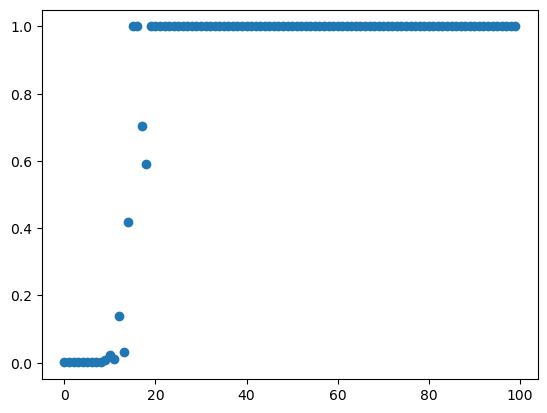

In [36]:
plt.scatter(range(df_blocks.shape[0]), df_blocks['FDR'])

### Compare results from different pipelines

In [48]:
xgb_up_df = pd.read_csv("result/DEG_cross_validation_v5_run1/common_genes_up.csv")
xgb_down_df = pd.read_csv("result/DEG_cross_validation_v5_run1/common_genes_down.csv")
dnn_up_df = pd.read_csv("result/DEG_DNN_v2/common_genes_up.csv")
dnn_down_df = pd.read_csv("result/DEG_DNN_v2/common_genes_down.csv")

In [49]:
xgboost_up_top = xgb_up_df.head(int(0.2 * xgb_up_df.shape[0]))
xgboost_down_top = xgb_down_df.head(int(0.2 * xgb_down_df.shape[0]))
dnn_up_top = dnn_up_df.head(int(0.02 * dnn_up_df.shape[0]))
dnn_down_top = dnn_down_df.head(int(0.02 * dnn_down_df.shape[0]))

In [50]:
xgboost_up_genes = xgboost_up_top["genes"].to_list()
xgboost_down_genes = xgboost_down_top["genes"].to_list()
dnn_up_genes = dnn_up_top["genes"].to_list()
dnn_down_genes = dnn_down_top["genes"].to_list()

In [51]:
edger_up_genes = pd.read_csv("result/DEG_Bing_Yang/up_genes.txt", header = None)[0].to_list()
edger_down_genes = pd.read_csv("result/DEG_Bing_Yang/down_genes.txt", header = None)[0].to_list()

In [52]:
def venn3_counts(a, b, c, title="",
                 labels=("A","B","C"), unweighted=True, show_zero=True):
    A, B, C = set(a), set(b), set(c)

    # format: numbers only; optionally hide zeros
    fmt = (lambda x: f"{int(x)}") if show_zero else (lambda x: "" if (x is None or x == 0) else f"{int(x)}")

    kwargs = dict(set_labels=labels, subset_label_formatter=fmt)
    if unweighted:  # force three visible, same-sized circles
        kwargs["layout_algorithm"] = DefaultLayoutAlgorithm(fixed_subset_sizes=(1,1,1,1,1,1,1))

    v = venn3([A, B, C], **kwargs)
    # venn3_circles([A, B, C], linewidth=1.5)  # outlines

    plt.title(title)
    plt.tight_layout()
    plt.show()

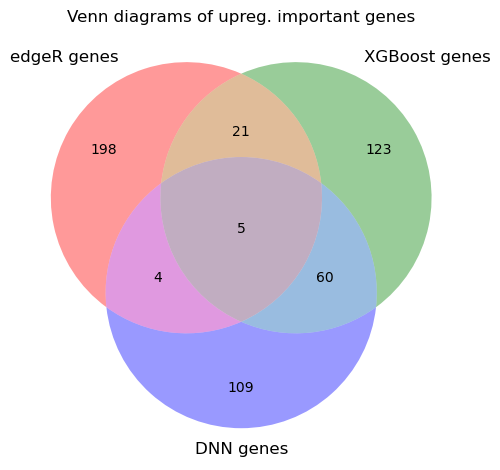

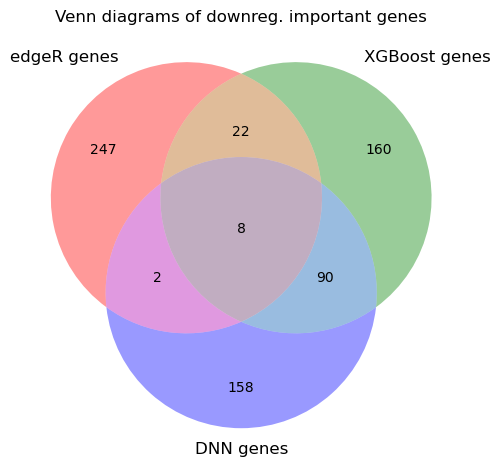

In [53]:
venn3_counts(edger_up_genes, xgboost_up_genes, dnn_up_genes, "Venn diagrams of upreg. important genes", 
                 labels = ("edgeR genes", "XGBoost genes", "DNN genes"))
venn3_counts(edger_down_genes, xgboost_down_genes, dnn_down_genes, "Venn diagrams of downreg. important genes", 
                 labels = ("edgeR genes", "XGBoost genes", "DNN genes"))

In [13]:
print(len(edger_up_genes), len(xgboost_up_genes), len(dnn_up_genes))

228 209 178


In [14]:
print(len(edger_down_genes), len(xgboost_down_genes), len(dnn_down_genes))

279 280 258
